In [203]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
from evrp.utils.utilities import create_optimal_edges, create_json_out, update_instance_json, read_instance_json_str, convert_txt_instances_to_csv, trace_routes
from evrp.utils.plot import plot_interactive_graph, plot_evrptwv2g
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np

import json

pd.options.plotting.backend = "plotly"

# Convert Schneider instance to E-VRP-TW-V2G

In [205]:
schneider_instance = 'rc105C5'
convert_txt_instances_to_csv(schneider_instance)

 # Full solve

Objective options: {Schneider} OR {OpEx CapEx Cycle EA DCM Delivery}

Constraint options: {Start=End, FullStart=End, NoXkappaBounds, NoMinVehicles, NoSymmetry, NoXd, SplitXp, StationaryEVs}

In [206]:
instance = 'r105C5_e'
fpath = 'config/test_instances/' + instance + '.csv'

In [259]:
m = EVRPTW(problem_type='Schneider Cycle nosymmetry stationaryevs splitxp bigm')
m.full_solve(fpath)

2021-07-01 14:02:18 INFO     Building abstract model
2021-07-01 14:02:18 INFO     Defining parameters and sets
2021-07-01 14:02:18 INFO     Defining variables
2021-07-01 14:02:18 INFO     Defining constraints
2021-07-01 14:02:18 INFO     Importing EVRPTW MILP instance: r105C5_e
2021-07-01 14:02:18 INFO     Reading CSV
2021-07-01 14:02:18 INFO     Creating graph
2021-07-01 14:02:18 INFO     Creating timeseries data
2021-07-01 14:02:18 INFO     Creating duplicates and extended graph
2021-07-01 14:02:18 INFO     Using Scipy euclidian distances to generate distance matrix
2021-07-01 14:02:18 INFO     Calculating distance matrix
2021-07-01 14:02:18 INFO     Creating parameters
2021-07-01 14:02:18 INFO     Creating instance
2021-07-01 14:02:24 INFO     Problem type: Schneider Cycle nosymmetry stationaryevs splitxp bigm
2021-07-01 14:02:43 INFO     Solving instance...


Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-08-14
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmp5ffija8z.pyomo.lp
Reading time = 0.20 seconds
x6949: 25819 rows, 3913 columns, 56154 nonzeros
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 25819 rows, 3913 columns and 56154 nonzeros
Model fingerprint: 0xcd8194c8
Variable types: 457 continuous, 3456 integer (3456 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [4e+00, 1e+03]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 6e+02]
Presolve removed 15931 rows and 838 columns
Presolve time: 1.24s
Presolved: 9888 rows, 3075 columns, 34652 nonzeros
Variable types: 304 continuous, 2771 integer (2771 bi

2021-07-01 14:04:50 WARNING  Loading a SolverResults object with an 'aborted' status, but containing a solution


    containing a solution


2021-07-01 14:04:53 INFO     Done


In [260]:
for k, v in m.instance.xkappa.get_values().items():
    if v>0:
        print(k)

('S0_2', 80)
('S0_2', 100)
('S0_3', 20)
('S13_0', 170)


In [231]:
print(m.results)


Problem: 
- Name: x6949
  Lower bound: 1138.0749620922727
  Upper bound: 2151.1487994612175
  Number of objectives: 1
  Number of constraints: 25634
  Number of variables: 3913
  Number of binary variables: 3456
  Number of integer variables: 3456
  Number of continuous variables: 457
  Number of nonzeros: 53531
  Sense: minimize
Solver: 
- Status: aborted
  Return code: 0
  Message: Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.
  Termination condition: maxTimeLimit
  Termination message: Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.
  Wall time: 120.05413889884949
  Error rc: 0
  Time: 120.85966205596924
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [265]:
for k, v in m.instance.xgamma_station_disjunction.items():
    print(k)
    for d in v.disjuncts:
        if d.indicator_var.value>0:
            print(d)
            if d.name.split('[')[0] != 'xgamma_station_off':
                for kk, vv in d.xkappa_station.items():
                    if vv.indicator_var.value>0:
                        print(kk)

S0_0
xgamma_station_off[S0_0]
xgamma_station_off
S0_1
xgamma_station[S0_1,S0_3]
xgamma_station
S0_2
xgamma_station[S0_2,C28]
xgamma_station
80
100
S0_3
xgamma_station[S0_3,C75]
xgamma_station
20
S1_0
xgamma_station_off[S1_0]
xgamma_station_off
S13_0
xgamma_station[S13_0,C95]
xgamma_station
170


2021-07-01 13:38:13 WARNING  5


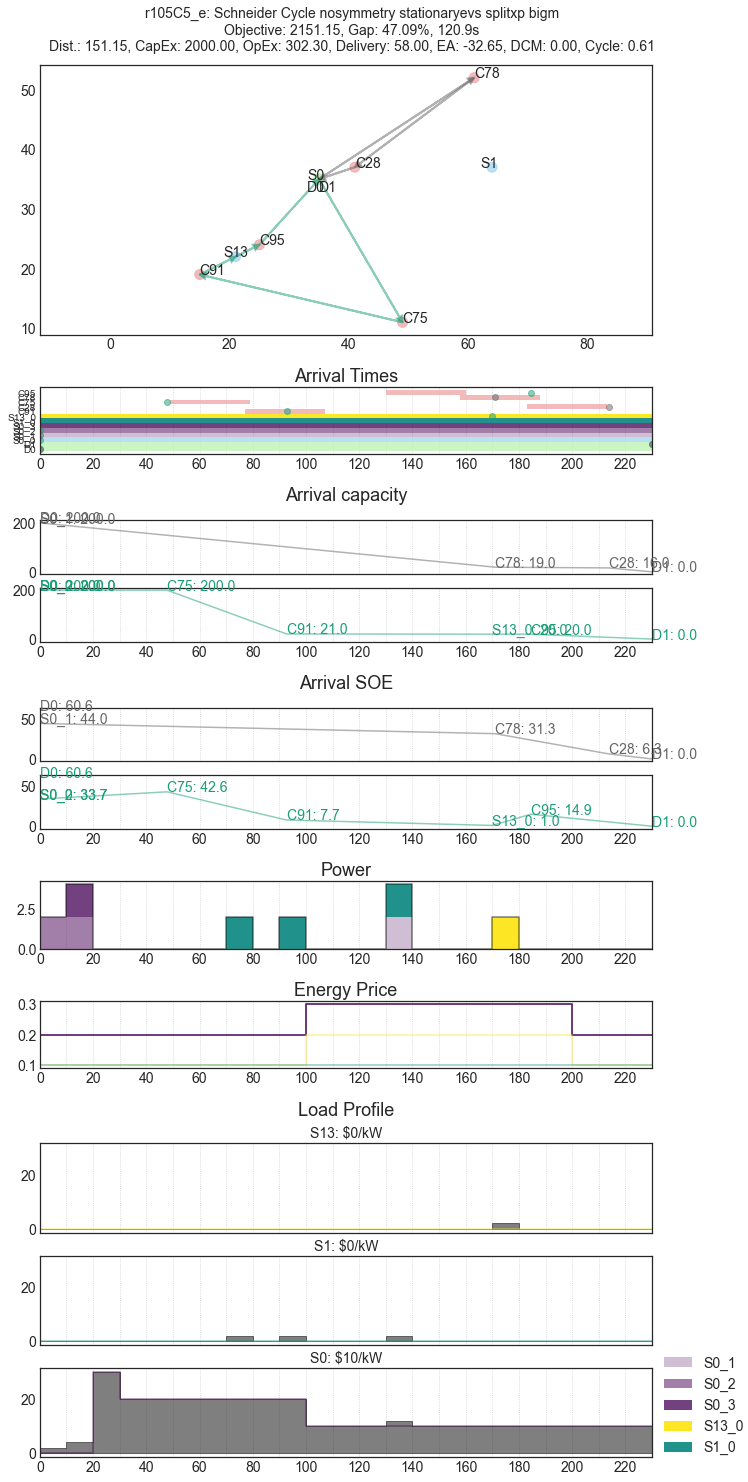

In [232]:
x, xp, traces, routes = plot_evrptwv2g(m, save=False)

In [ ]:
dfs = []
for k, v in {'xp': m.instance.xp, 'xc': m.instance.xc, 'xg': m.instance.xg}.items():
    dfs.append(pd.DataFrame.from_dict(data=v.get_values(), orient='index', columns=[k]))
df = pd.concat(dfs, axis=1)
df[(df>0).any(axis=1)]

In [ ]:
routes

In [ ]:
trace_routes(m)

In [ ]:
m.data['d']

# Archive, fix route, modify objective, and warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.remake_objective(m.instance, 'Opex Capex EA DCM cycle')

In [ ]:
m.warmstart_solve()

In [ ]:
print(m.results)

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

# Archive, rebuild model to modify constraints, fix route, warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.instance_archive

In [ ]:
m.remake_model('Opex Capex EA DCM cycle wsplitxgamma', fpath)

In [ ]:
m.set_xgamma('Opex Capex EA DCM cycle')

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.make_solver(solve_options={'TimeLimit': 60 * 5})

In [ ]:
m.warmstart_solve()

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

In [ ]:
routes

# Check infeasible constraints

In [ ]:
from pyomo.util.infeasible import log_infeasible_constraints

In [ ]:
log_infeasible_constraints(m.instance)